In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor


## Predict rent prices
1. Use pipeline
2. Cross validation
3. XGBoost

In [2]:
raw_data = pd.read_csv("../input/house-rent-prediction-dataset/House_Rent_Dataset.csv")
print(raw_data.shape)
raw_data.head(1)

(4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner


In [3]:
# Drop unnecessary columns, and seperate the target column
drop_col = ['Posted On', 'Rent', 'Tenant Preferred', 'Point of Contact', 'Floor', 'Area Locality']
target = raw_data['Rent']
raw_data_aug = raw_data.drop(columns=drop_col)
print(f"raw_data_aug shape:", raw_data_aug.shape)
print(raw_data_aug.info())
raw_data_aug.head()

raw_data_aug shape: (4746, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   BHK                4746 non-null   int64 
 1   Size               4746 non-null   int64 
 2   Area Type          4746 non-null   object
 3   City               4746 non-null   object
 4   Furnishing Status  4746 non-null   object
 5   Bathroom           4746 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 222.6+ KB
None


,BHK,Size,Area Type,City,Furnishing Status,Bathroom
0,2,1100,Super Area,Kolkata,Unfurnished,2
1,2,800,Super Area,Kolkata,Semi-Furnished,1
2,2,1000,Super Area,Kolkata,Semi-Furnished,1
3,2,800,Super Area,Kolkata,Unfurnished,1
4,2,850,Carpet Area,Kolkata,Unfurnished,1


In [4]:
# Split raw data into train and test
X_train, X_test, y_train, y_test = train_test_split(raw_data_aug, target, test_size=0.25)
print(f"Train split: ",X_train.shape, y_train.shape)
print(f"Test split: ",X_test.shape, y_test.shape)

Train split:  (3559, 6) (3559,)
Test split:  (1187, 6) (1187,)


In [5]:
# Split prior train into train and validation
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(f"Train split: ",x_train.shape, y_train.shape)
print(f"Validation split: ",x_valid.shape, y_valid.shape)

Train split:  (2847, 6) (2847,)
Validation split:  (712, 6) (712,)


## Use Pipeline

In [6]:
num_cols = [cname for cname in x_train.columns if x_train[cname].dtype in ['int32', 'int64']]
cat_cols = [cname for cname in x_train.columns if x_train[cname].dtype=='object']
print(num_cols)
print(cat_cols)

['BHK', 'Size', 'Bathroom']
['Area Type', 'City', 'Furnishing Status']


In [7]:
numerical_transform = SimpleImputer(strategy="most_frequent")
categorical_transform = Pipeline(steps=[
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore')) # LabelEncoder doesnt work, why sparse=False?
])

preprocessing = ColumnTransformer(transformers=[
    ('num',numerical_transform,num_cols),
    ('cat', categorical_transform,cat_cols)
])

In [8]:
model = RandomForestRegressor()

In [9]:
my_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('model', model)
])
my_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['BHK', 'Size', 'Bathroom']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Area Type', 'City',
                                                   'Furnishing Status'])])),
                ('model', RandomForestRegressor())])

In [10]:
my_pipeline = my_pipeline.fit(x_train, y_train)
preds = my_pipeline.predict(x_valid)

In [11]:
# Compare preds to actual
print("Valid MAE:", mean_absolute_error(y_valid, preds))

Valid MAE: 16165.563361530221


In [12]:
# Generate predictions on test set
test_preds = my_pipeline.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_preds))
pd.DataFrame(test_preds)

Test MAE: 12671.673098730149


,0
0,9373.916667
1,27201.666667
2,49060.000000
3,9990.752345
4,27003.442460
...,...
1182,11437.607501
1183,12812.420027
1184,89277.562771
1185,6082.750000


## Cross Validation

In [13]:
def get_score(n_estimators):
    model = RandomForestRegressor(n_estimators, random_state=1)
    my_pipeline = Pipeline(steps=[
        ('preprocess', preprocessing),
        ('model', model)
    ])
    
    scores = -1 * cross_val_score(my_pipeline, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return scores.mean()

In [14]:
get_score(50)

13386.174193545006

In [15]:
results = {}
for i in range(1, 9):
    results[i*50] = get_score(i*50)

In [16]:
results

{50: 13386.174193545006,
 100: 13325.444097433723,
 150: 13289.966661527065,
 200: 13276.523472142839,
 250: 13248.122517172149,
 300: 13237.499089715717,
 350: 13233.811311964495,
 400: 13221.958958645488}

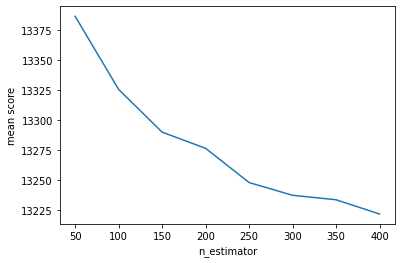

In [17]:
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('n_estimator')
plt.ylabel('mean score')
plt.show()

## XG Boost

In [18]:
model = XGBRegressor()

my_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('model', model)
])

In [19]:
my_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['BHK', 'Size', 'Bathroom']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Area Type', 'City',
                                                   'Furnishing Status'])])),
                ('model',
                 XGBRegressor(base_score.

In [20]:
predictions = my_pipeline.predict(x_valid)

mae = mean_absolute_error(y_valid, predictions)
mae